<a id='top'></a>

# Построение классификатора дорожных знаков по изображению

## Задача

* Обучить мультиклассовый классификатор дорожных знаков по изображению на датасете немецких дорожных знаков ["German Traffic Sign Recognition Benchmark" (GTSRB)](http://benchmark.ini.rub.de/?section=gtsrb);
* Оценить на тестовой выборке на CPU точность и скорость работы классификатора.

<a id='toc'></a>

В рамках решения поставленной задачи был проведен анализ научных статей в области распознавания дорожных знаков по изображениям. Сам анализ в данной работе представлен не будет.

По результатам анализа для реализации была выбрана нейросетевая модель, предлагаемая в данной статье - [MicronNet: A Highly Compact Deep Convolutional Neural Network Architecture for Real-time Embedded Traffic Sign Classification](https://arxiv.org/pdf/1804.00497v3.pdf). Она была выбрана мной ввиду впечатляющего соотношения точности классификации к размерам самой модели.

## План решения:

0. [Установка необходимых пакетов](#step0);
1. [Скачивание данных](#step1);
2. [EDA по данным](#step2);
3. [Препроцессинг данных перед этапом обучения модели](#step3);
4. [Обучение модели](#step4);
5. [Оценка качества на тестовой выборке](#step5);
6. [Анализ ошибок предсказаний модели](#step6);
7. [(Дополнительно) Оценка качества на реальных данных](#step7).

# Решение:

<a id='step0'></a>

## 0. Установка необходимых пакетов<sup>[toc](#toc)</sup>

In [1]:
# Если используете Google Colab и нет желания авторизовываться в github
# для скачивания остальных файлов, то раскомментируйте следующие две строчки
# !wget https://raw.githubusercontent.com/nikitkaa/keras-micronnet/master/requirements.txt
# !wget https://raw.githubusercontent.com/nikitkaa/keras-micronnet/master/sign_names.txt
!pip install -r requirements.txt

     |████████████████████████████████| 81kB 583kB/s eta 0:00:01
     |████████████████████████████████| 122kB 2.0MB/s eta 0:00:01
     |████████████████████████████████| 14.4MB 1.8MB/s eta 0:00:01    |████████████▌                   | 5.6MB 2.7MB/s eta 0:00:04
     |████████████████████████████████| 15.0MB 115kB/s eta 0:00:01    |██▍                             | 1.1MB 2.7MB/s eta 0:00:06     |██████████████████████████████▋ | 14.3MB 1.2MB/s eta 0:00:01
     |████████████████████████████████| 71kB 492kB/s eta 0:00:01
     |████████████████████████████████| 266kB 513kB/s eta 0:00:01
     |████████████████████████████████| 27.7MB 4.3MB/s eta 0:00:01     |███████████████▋                | 13.5MB 2.6MB/s eta 0:00:06
  Stored in directory: /private/var/folders/86/mp051pxj0j3_y5q09_szndh80000gn/T/pip-ephem-wheel-cache-govtvpih/wheels/82/84/c5/2b0b96a6ab7c641c86372f956d80ec299e88706d87c698fa65
  Stored in directory: /private/var/folders/86/mp051pxj0j3_y5q09_szndh80000gn/T/pip-ephem-wheel-cac

#### Необходимые импорты

In [1]:
%load_ext autoreload
%autoreload 2

import glob
import os
import random as rn
from collections import Counter

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
import tensorflow.keras.layers as kl
from albumentations import (
    ShiftScaleRotate, GaussianBlur, MotionBlur, IAASharpen,
    HueSaturationValue, HorizontalFlip, OneOf, Compose
)
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import Sequence


/Users/macbook/Myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/macbook/Myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/macbook/Myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/macbook/Myenv/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:5

Зафиксируем random seed, для воспроизводимости результатов

In [2]:
# fix random seed
def get_seed():
    # python seed
    os.environ['PYTHONHASHSEED'] = '0'
    rn.seed(12345)

    # numpy seed
    np.random.seed(42)

    # tf seed
    tf.set_random_seed(1234)
    
get_seed()

<a id='step1'></a>

## 1. Скачивание данных<sup>[toc](#toc)</sup>

In [3]:
!mkdir data

!curl --url https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Training_Images.zip -o data/GTSRB_Final_Training_Images.zip
!curl --url https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_Images.zip -o data/GTSRB_Final_Test_Images.zip
!curl --url https://sid.erda.dk/public/archives/daaeac0d7ce1152aea9b61d9f1e19370/GTSRB_Final_Test_GT.zip -o data/GTSRB_Final_Test_GT.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  263M  100  263M    0     0  1453k      0  0:03:05  0:03:05 --:--:-- 1800kk      0  0:04:00  0:00:11  0:03:49 1239k   0  0:03:18  0:00:25  0:02:53 1654k0:03:27  0:01:04  0:02:23 1564k    0  1305k      0  0:03:26  0:01:07  0:02:19 1496k29M    0     0  1392k      0  0:03:13  0:01:35  0:01:38 1580k  1434k      0  0:03:08  0:02:49  0:00:19 1491k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 84.8M  100 84.8M    0     0  1456k      0  0:00:59  0:00:59 --:--:-- 1683k  0  1000k      0  0:01:26  0:00:02  0:01:24 1000k  0:01:11  0:00:20  0:00:51 1431k2k      0  0:01:06  0:00:24  0:00:42 1692k01:05  0:00:26  0:00:39 1549k     0  0:01:04  0:00:30  0:00:34 1507k46.6M    0     0  1392k      0  0:01:02  0:00:34  0:00:28 1755k
 

In [4]:
!ls data

GTSRB_Final_Test_GT.zip         GTSRB_Final_Training_Images.zip
GTSRB_Final_Test_Images.zip


In [5]:
!unzip data/GTSRB_Final_Training_Images.zip -d data/ > /dev/null 2>&1
!unzip data/GTSRB_Final_Test_Images.zip -d data/ > /dev/null 2>&1
!unzip data/GTSRB_Final_Test_GT.zip -d data/

Archive:  data/GTSRB_Final_Test_GT.zip
  inflating: data/GT-final_test.csv  


<a id='step2'></a>

## 2. EDA по данным<sup>[toc](#toc)</sup>

Рассмотрим объемы имеющихся выборок

In [6]:
print('Количество классов в датасете: {}'.format(len(glob.glob('data/GTSRB/Final_Training/Images/*'))))
print('Количество примеров для обучения: {}'.format(len(glob.glob('data/GTSRB/Final_Training/Images/*/*.ppm'))))
print('Количество примеров в тестовой выборке: {}'.format(len(glob.glob('data/GTSRB/Final_Test/Images/*.ppm'))))

Количество классов в датасете: 43
Количество примеров для обучения: 39209
Количество примеров в тестовой выборке: 12630


Посмотрим на изображения

In [9]:
def get_sign_names_mapping(filepath):
    idx2sign_name = {}
    with open(filepath, 'r') as f:
        for idx, sign_name in enumerate(f):
            idx2sign_name[idx] =  sign_name.strip()
    return idx2sign_name

/Users/macbook/Myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if __name__ == '__main__':


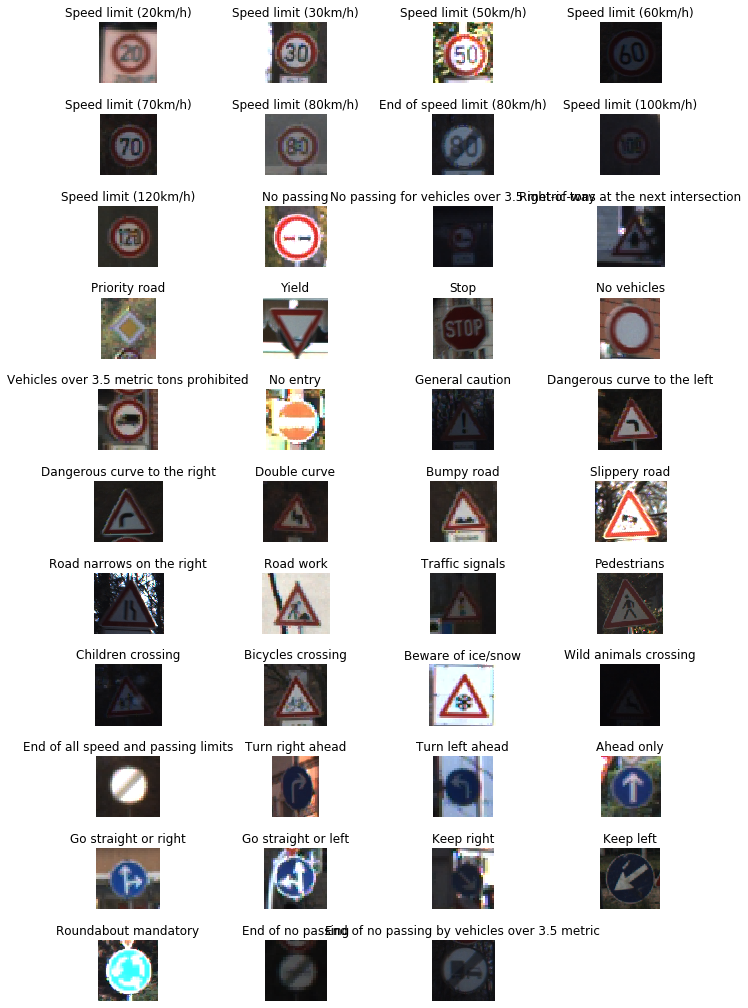

In [10]:
TRAIN_IMAGES_DIR = 'data/GTSRB/Final_Training/Images'
NUM_CLASSES = 43

n_rows, n_cols = 11, 4

idx2sign_name = get_sign_names_mapping(filepath='sign_names.txt')

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,18), constrained_layout=True)
fig.subplots_adjust(hspace=0.5, wspace=0.0)

for idx, class_path in enumerate(sorted(glob.glob(TRAIN_IMAGES_DIR + '/*'))):
    img_path = np.random.choice(glob.glob(class_path + '/*.ppm'))
    raw_img = cv2.imread(img_path)
#     rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    axs[idx // n_cols, idx % n_cols].set_title(idx2sign_name[idx])
    axs[idx // n_cols, idx % n_cols].grid(False)
    axs[idx // n_cols, idx % n_cols].axis('off')
    axs[idx // n_cols, idx % n_cols].imshow(rgb_img)
axs[NUM_CLASSES // n_cols, NUM_CLASSES % n_cols].grid(False)
axs[NUM_CLASSES // n_cols, NUM_CLASSES % n_cols].axis('off')
plt.show()

На изобрежаниях заметен сильный перепад яркости между классами, а также видно, что изображения имеют разные соотношения сторон - пример Children crossing и Bicycles crossing.

Помимо rgb изображений в датасете присутствиуют табличные данные, описывающие следующие параметры каждого изображения:

* Наименование файла изображения - Filename;
* Ширина и высота изображения в пикселях - Width и Height, соответственно;
* Координаты левой верхней и правой нижней точек прямоугольника обрамляющего знак - (Roi.X1, Roi.Y1), (Roi.X2, Roi.Y2);
* Указание класса, которому принадлежит знак - ClassId

Для удобства объединим все таблицы в один DataFrame

In [11]:
annotation_paths = sorted(glob.glob('data/GTSRB/Final_Training/*/*/*csv'))

annotation_df = pd.concat([pd.read_csv(path, sep=';') for path in annotation_paths], ignore_index=True)
annotation_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,29,30,5,6,24,25,0
1,00000_00001.ppm,30,30,5,5,25,25,0
2,00000_00002.ppm,30,30,5,5,25,25,0
3,00000_00003.ppm,31,31,5,5,26,26,0
4,00000_00004.ppm,30,32,5,6,25,26,0


Определим для каждого файла соответствующий ему (физический) знак

In [12]:
annotation_df['unique_sign'] = annotation_df['ClassId'].astype(str).str.zfill(5) + "/" + annotation_df['Filename'].str.split('_', expand=True)[0]
annotation_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,unique_sign
0,00000_00000.ppm,29,30,5,6,24,25,0,00000/00000
1,00000_00001.ppm,30,30,5,5,25,25,0,00000/00000
2,00000_00002.ppm,30,30,5,5,25,25,0,00000/00000
3,00000_00003.ppm,31,31,5,5,26,26,0,00000/00000
4,00000_00004.ppm,30,32,5,6,25,26,0,00000/00000


In [13]:
annotation_df['unique_sign'].value_counts()

00004/00029    30
00013/00065    30
00004/00008    30
00005/00047    30
00005/00035    30
00004/00050    30
00025/00013    30
00007/00000    30
00013/00029    30
00005/00031    30
00025/00038    30
00009/00029    30
00034/00002    30
00017/00027    30
00010/00006    30
00011/00025    30
00022/00003    30
00038/00045    30
00002/00058    30
00033/00020    30
00022/00000    30
00013/00014    30
00008/00044    30
00001/00016    30
00009/00013    30
00007/00039    30
00007/00004    30
00002/00051    30
00007/00007    30
00002/00060    30
               ..
00024/00000    30
00025/00039    30
00039/00001    30
00010/00021    30
00014/00011    30
00017/00031    30
00026/00014    30
00025/00028    30
00025/00035    30
00005/00042    30
00011/00023    30
00010/00018    30
00012/00000    30
00038/00005    30
00005/00017    30
00013/00046    30
00001/00011    30
00015/00001    30
00002/00043    30
00002/00056    30
00013/00032    30
00013/00064    30
00038/00016    30
00012/00008    30
00023/0000

In [14]:
len(annotation_df['unique_sign'].unique())

1307

Всего в обучающей выборке 1307 уникальных знаков, по 30 изображений на каждый знак (кроме одного - 29 изображений с таким знаком).

Рассмотрим, меняется ли яркость изображений а разрезе одного класса.

/Users/macbook/Myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  if __name__ == '__main__':


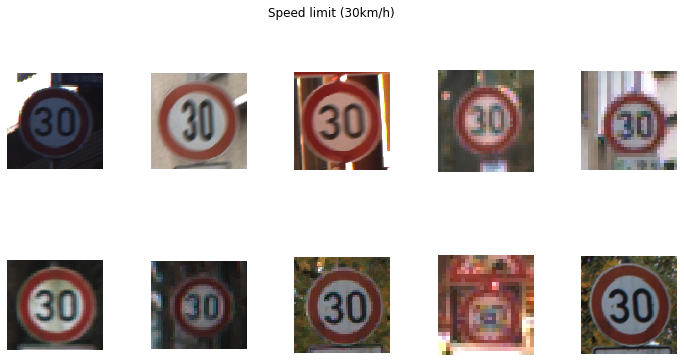

In [15]:
sign_class_number = 1

n_rows, n_cols = 2, 5

sign_samples = annotation_df.query('ClassId == @sign_class_number') # pd.Dataframe
sign_samples = sign_samples['unique_sign'].sample(n=n_rows*n_cols, random_state=42) # pd.Series

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,6), constrained_layout=True)
fig.subplots_adjust(hspace=0.3, wspace=0.5)
fig.suptitle(idx2sign_name[sign_class_number])

for idx, sign in enumerate(sign_samples.values):
    filename = np.random.choice(annotation_df.query('unique_sign == @sign')['Filename'].values, size=1)[0]
    img_path = os.path.join(TRAIN_IMAGES_DIR, '{0:0>5}'.format(sign_class_number), filename) #train_images_dir
    raw_img = cv2.imread(img_path)
    rgb_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    axs[idx // n_cols, idx % n_cols].grid(False)
    axs[idx // n_cols, idx % n_cols].axis('off')
    axs[idx // n_cols, idx % n_cols].imshow(rgb_img)
plt.show()

Посмотрим на распределение классов в обучающей выборке

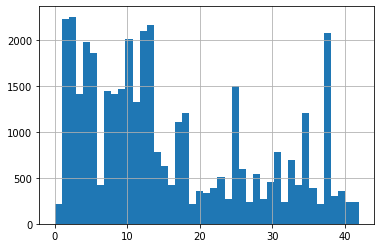

In [16]:
annotation_df['ClassId'].hist(bins=NUM_CLASSES)

#### Итог:
* На изображениях в выборке заметны сильные перепады яркости, это означает, что в этап препроцессинга изображений стоит включить эквализацию гистограммы изображений.
* Разнообразие соотношений сторон изображений, подталкивает к следующему подходу - стоит вырезать изображений дорожного знака по его обрамляющему прямоугольнику, после чего изменять размер изображения до квадратного, например 48*48.
* Классы не сбалансированы - стоит ввести class weight для достижения баланса при обучении, а также стоит расширить выборку аугментациями;

<a id='step3'></a>

## 3. Препроцессинг данных перед этапом обучения модели<sup>[toc](#toc)</sup>

Напишем ряд вспомогательных функций для препроцессинга изображений. Для обучения модели подготовим датагенератор, который будет выполнять следующую последовательность действий для каждого изображения:

* Загрузить изображение в память по данному пути к нему;
* Предобработка изображения
 * Выровнять яркость изображения с помощью эквализации гистограммы;
 * Вырезать изображение знака из исходного изображения по известным коодинатам;
 * Изменить размер изображения до заранее выбранного;
* Аугментировать изображение.

Подготовим датафрейм для удобного извлечения информации о конкретном изображении.

### Датагенератор

In [17]:
train_df = annotation_df.set_index(['ClassId','Filename'])
train_df.loc[0].loc['00000_00000.ppm']

Width                   29
Height                  30
Roi.X1                   5
Roi.Y1                   6
Roi.X2                  24
Roi.Y2                  25
unique_sign    00000/00000
Name: 00000_00000.ppm, dtype: object

In [18]:
def get_img_class(img_path):
    return int(img_path.split('/')[-2])
    
get_img_class(os.path.join(TRAIN_IMAGES_DIR, '00011/00000_00000.ppm'))

11

Извлечение координат точек обрамляющего прямоугольника по данному пути к файлу

In [19]:
def get_sign_coords(img_path, is_train=True):
    im_name = img_path.split('/')[-1]
    
    if is_train:
        pic_class = get_img_class(img_path)
        df_row = train_df.loc[pic_class].loc[im_name]
    else:
        df_row = test_df.loc[im_name]
    
    x1, y1, x2, y2 = df_row['Roi.X1'], df_row['Roi.Y1'], df_row['Roi.X2'], df_row['Roi.Y2']
    return (x1, y1, x2, y2)
    
get_sign_coords(os.path.join(TRAIN_IMAGES_DIR, '00011/00000_00000.ppm'))

(5, 6, 22, 21)

Аугментации изображений (взяты аналогичные используемым в статье)

In [22]:
def get_aug(p=0.5):
    return Compose([
        OneOf([
            MotionBlur(p=0.1),
            GaussianBlur(p=0.1),
        ], p=0.2),
        ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20,
                         p=0.2, border_mode=cv2.BORDER_REPLICATE),
        IAASharpen(p=0.2),
        HueSaturationValue(p=0.3),
    ], p=p)

augmentation = get_aug(p=0.8)

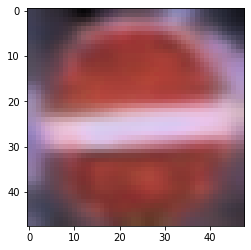

In [21]:
def preprocess_img(img_path):
    bgr_img = cv2.imread(img_path)
    
    hsv_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2HSV)
    hsv_img[...,2] = cv2.equalizeHist(hsv_img[...,2])
    
    rgb_img = cv2.cvtColor(hsv_img, cv2.COLOR_HSV2RGB)
    return rgb_img

def crop_n_resize_img(img, pt1, pt2, dsize):
    (x1, y1), (x2, y2) = pt1, pt2
    cropped_img = img[y1:y2, x1:x2]
    resized_img = cv2.resize(cropped_img, (dsize,dsize))
    return resized_img
    

def augment_img(augmentation, img):
    res_img = augmentation(image=img)['image']
    return res_img

img_path = os.path.join(TRAIN_IMAGES_DIR, '00017/00000_00015.ppm')
x1, y1, x2, y2 = get_sign_coords(img_path)

processed_img = preprocess_img(img_path)
resized_img = crop_n_resize_img(processed_img, (x1,y1), (x2,y2), dsize=48)
augmented_img = augment_img(augmentation, resized_img)

plt.imshow(augmented_img)
plt.show()

Напишем класс датагенератора, работающего с путями к исходным изображениям.

In [31]:
class DataGenerator(Sequence):

    def __init__(self, path_list, labels, n_classes, batch_size, img_size,
                 n_channels, shuffle=True, use_augs=False, is_train=True):
        self.img_size = img_size
        self.batch_size = batch_size
        self.labels = labels
        self.path_list = path_list
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.use_augs = use_augs
        self.is_train = is_train
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.path_list) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X, y = self.__data_generation(indexes)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.path_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, self.img_size, self.img_size, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        for i, idx in enumerate(indexes):
            img_path = self.path_list[idx]
            processed_img = preprocess_img(img_path)
            x1, y1, x2, y2 = get_sign_coords(img_path, is_train=self.is_train)
            resized_img = crop_n_resize_img(processed_img, (x1,y1), (x2,y2), dsize=self.img_size)
            augmented_img = augment_img(augmentation, resized_img)
            
            X[i] = augmented_img / 255
            y[i] = self.labels[idx]

        return X, tensorflow.keras.utils.to_categorical(y, num_classes=self.n_classes)

### Train dev split

Произведем стратифицированное разбиение обучающей выборки на две следующие:

* Подвыборка для обучения модели;
* Подвыборка для подбора гиперпараметров и оценки качества в процессе обучения.

Разбиение будем производить по уникальным знакам из выборки, это сделано во избежание подмешавания изображений одного и того же знака в обе подвыборки.

Разбиение производится в соотношении: "Обучение" 75% - "Оценка качества" 25%.

In [32]:
sign_list = annotation_df['unique_sign'].unique()
labels = [get_img_class(sign_name) for sign_name in sign_list]

train_signs, dev_signs = train_test_split(sign_list, train_size=0.75, 
                                          stratify=labels, random_state=123)

train_paths = []
for sign_name in train_signs:
    train_paths.extend(glob.glob(os.path.join(TRAIN_IMAGES_DIR, sign_name + '*.ppm')))
    
dev_paths = []
for sign_name in dev_signs:
    dev_paths.extend(glob.glob(os.path.join(TRAIN_IMAGES_DIR, sign_name + '*.ppm')))

train_labels = [get_img_class(sign_name) for sign_name in train_paths]
dev_labels = [get_img_class(sign_name) for sign_name in dev_paths]
len(train_labels), len(dev_labels), len(train_paths), len(dev_paths)

/Users/macbook/Myenv/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


(29399, 9810, 29399, 9810)

Также введем веса class_weight для балансировки классов при обучении

In [33]:
def create_class_weight(labels_dict, mu=0.15):
    total = np.sum(list(labels_dict.values()))
    keys = labels_dict.keys()
    class_weight = dict()

    for key in keys:
        score = np.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0

    return class_weight


labels_dict = Counter(labels)

class_weight = create_class_weight(labels_dict)

<a id='step4'></a>

## 4. Обучение модели<sup>[toc](#toc)</sup>

В данном разделе воспроизведен процесс обучения модели по его описанию в статье:

* Подход оптимизации функции потерь - SGD (learning rate = 0.007) с Momentum (momentum value = 0.9);
* Экспоненциальное уменьшение learning rate с коэффициентом 0.9996 каждые 2 эпохи обучения;
* L2 регуляризация на сверточных фильтрах и матрицах полносвязных слоёв с коэффициентом регуляризации 0.00001.

Ниже описана архитектура модели.

In [86]:
IMG_SIZE = 48
l2_reg_rate = 1e-5
eps = 1e-6

def get_micronet():
    input_ = kl.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='data')
    # 1-part
    x = kl.Conv2D(filters=1, kernel_size=(1,1), padding='same', kernel_regularizer=l2(l2_reg_rate))(input_)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    # 2-part
    x = kl.Conv2D(filters=29, kernel_size=(5,5), kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.MaxPooling2D(pool_size=3, strides=2)(x)
    # 3-part
    x = kl.Conv2D(filters=59, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.MaxPooling2D(pool_size=3, strides=2)(x)
    # 4-part
    x = kl.Conv2D(filters=74, kernel_size=(3,3), padding='same', kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.MaxPooling2D(pool_size=3, strides=2)(x)
    # 5-part
    x = kl.Flatten()(x)
    x = kl.Dense(300, kernel_regularizer=l2(l2_reg_rate))(x)
    x = kl.BatchNormalization(epsilon=eps)(x)
    x = kl.ReLU()(x)
    x = kl.Dense(300)(x)
    x = kl.ReLU()(x)
    x = kl.Dense(NUM_CLASSES)(x)
    x = kl.Softmax()(x)
    return Model(inputs=input_, outputs=x)


In [84]:
BATCH_SIZE = 50

train_generator = DataGenerator(
    path_list=train_paths,
    labels=train_labels,
    n_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channels=3,
    shuffle=True,
    use_augs=True,
)

dev_generator = DataGenerator(
    path_list=dev_paths,
    labels=dev_labels,
    n_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channels=3,
    shuffle=True,
    use_augs=False,
)

In [85]:
def create_lr_decay(decay_step_size, lr_decay_rate):
    def lr_decay(epoch, lr):
        if epoch % decay_step_size == 0:
            lr = lr * lr_decay_rate
        return lr
    return lr_decay

lr = 0.0007
lr_decay = create_lr_decay(decay_step_size=2, lr_decay_rate=0.9996)

In [39]:
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)

model_name = '2019-08-05-micronnet'

monitor = 'val_categorical_accuracy'
model_path = os.path.join(weights_path, model_name + '-epoch-{epoch:02d}-val_cat_acc-{val_categorical_accuracy:.3f}.hdf5')

model_checkpoint = ModelCheckpoint(model_path, monitor=monitor, save_best_only=True, verbose=1)
lr_sched = LearningRateScheduler(lr_decay)

callbacks = [
    model_checkpoint,
    lr_sched,
]

In [40]:
K.clear_session()

model = get_micronet()

opt = tensorflow.keras.optimizers.SGD(
    learning_rate=lr,
    momentum=0.9,
    nesterov=True,
)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

W0807 16:09:35.847685 4489119168 deprecation.py:506] From /Users/macbook/Myenv/lib/python3.7/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [ ]:
model.fit_generator(
    generator=train_generator,
    epochs=100,
    callbacks=callbacks,
    validation_data=dev_generator,
    class_weight=class_weight,
)

<a id='step5'></a>
## 5. Оценка качества на тестовой выборке<sup>[toc](#toc)</sup>

In [70]:
loaded_model = model

In [71]:
TEST_IMAGES_DIR = 'data/GTSRB/Final_Test/Images'


In [77]:
test_df = pd.read_csv('data/GT-final_test.csv', sep=';')
test_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11


In [78]:
test_paths = TEST_IMAGES_DIR + os.sep + test_df['Filename']
test_labels = test_df['ClassId']
(test_paths[2], test_labels[2]), (test_paths[4], test_labels[4]),

(('data/GTSRB/Final_Test/Images/00002.ppm', 38),
 ('data/GTSRB/Final_Test/Images/00004.ppm', 11))

In [79]:
test_df = test_df.set_index('Filename')

In [80]:
test_generator = DataGenerator(
    path_list=test_paths,
    labels=test_labels,
    n_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    img_size=IMG_SIZE,
    n_channels=3,
    shuffle=True,
    use_augs=False,
    is_train=False
)

In [81]:
loaded_model.evaluate_generator(test_generator)

[3.752135373297192, 0.03793651]

In [82]:
loaded_model.metrics_names

['loss', 'categorical_accuracy']

<a id='step6'></a>
## 6. Анализ ошибок предсказаний модели<sup>[toc](#toc)</sup>

<a id='step7'></a>

## 7. (Дополнительно) Оценка качества на реальных данных<sup>[toc](#toc)</sup>

<a href="#top">Вернуться в начало тетрадки</a>